In [77]:
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import copy

In [78]:
CHEAP = 100_000
EXPENSIVE = 350_000
SEED = 200
torch.manual_seed(SEED)
np.random.seed(SEED)

In [79]:
df = pd.read_csv("train_data.csv", sep=',')
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


In [80]:
#plt.hist(df["YearBuilt"])
#plt.show()
class_nr = 0
for i in range(df['YearBuilt'].min(), df['YearBuilt'].max(), 5):
    df["YearBuilt"].mask( (df['YearBuilt']>=i) & (df['YearBuilt'] < i+5), class_nr, inplace=True)
    class_nr += 1
df['YearBuilt'].describe()
#plt.hist(df["YearBuilt"])
#plt.show()

count    4124.000000
mean        4.558923
std         1.801223
min         0.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         7.000000
Name: YearBuilt, dtype: float64

In [81]:
df['SalePrice'].mask(df['SalePrice'] <= CHEAP, 0, inplace=True)
df['SalePrice'].mask((df['SalePrice'] > CHEAP) & (df['SalePrice'] <= EXPENSIVE), 1, inplace=True)
df['SalePrice'].mask(df['SalePrice'] > EXPENSIVE, 2, inplace=True)


categorical_columns = [
    'YearBuilt', 'HallwayType', 'HeatingType',
    'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation',
]
categorical_values = pd.get_dummies(df[categorical_columns].astype(str))
df.drop(columns=categorical_columns, inplace=True)
categorical_values.head()

,YearBuilt_0,YearBuilt_1,YearBuilt_2,YearBuilt_3,YearBuilt_5,YearBuilt_6,YearBuilt_7,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [82]:
train_indices = np.random.rand(len(df))>0.25
print(train_indices)
print(~train_indices)

[ True False  True ...  True  True  True]
[False  True False ... False False False]


In [83]:
targets = df['SalePrice'][train_indices].to_numpy()
test_targets = df['SalePrice'][~train_indices].to_numpy()

df = df.drop('SalePrice', axis=1)

numerical_data = df.values[train_indices,:]
test_numerical_data = df.values[~train_indices,:]

categorical_data = categorical_values.values[train_indices,:]
test_categorical_data = categorical_values.values[~train_indices,:]

In [84]:
ss = StandardScaler()
numerical_data = ss.fit_transform(numerical_data)
test_numerical_data = ss.transform(test_numerical_data)

In [85]:
targets = torch.from_numpy(targets).float()
test_targets = torch.from_numpy(test_targets).float()

numerical_data = torch.from_numpy(numerical_data).float()
test_numerical_data = torch.from_numpy(test_numerical_data).float()

categorical_data = torch.from_numpy(categorical_data).float()
test_categorical_data = torch.from_numpy(test_categorical_data).float()

In [86]:
train_dataset = data.TensorDataset(numerical_data, categorical_data, targets)
test_dataset = data.TensorDataset(test_numerical_data, test_categorical_data, test_targets)
print(train_dataset[:][0].shape, train_dataset[:][1].shape)
print(test_dataset[:][0].shape, test_dataset[:][1].shape)
print((train_dataset[:][2]==0).sum())
print((train_dataset[:][2]==1).sum())
print((train_dataset[:][2]==2).sum())

print((test_dataset[:][2]==0).sum())
print((test_dataset[:][2]==1).sum())
print((test_dataset[:][2]==2).sum())

torch.Size([3078, 9]) torch.Size([3078, 30])
torch.Size([1046, 9]) torch.Size([1046, 30])
tensor(404)
tensor(2246)
tensor(428)
tensor(158)
tensor(746)
tensor(142)


In [87]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(numerical_data.shape[1] + categorical_data.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act_1 = nn.ReLU()
        self.d1 = nn.Dropout(0.35)
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act_2 = nn.ReLU()
        self.d2 = nn.Dropout(0.35)
        self.layer3 = nn.Linear(64, 3)


    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_1(x)
        x = self.d1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_2(x)
        x = self.d2(x)
        output = self.layer3(x)
        return output

In [70]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset[:][2]), y=train_dataset[:][2].numpy())
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights = torch.from_numpy(np.array([2,1,2])).float()
class_weights

tensor([2., 1., 2.])

In [74]:
LEARN_RATE = 0.0001
NUM_EPOCHS = 30

model = Model()
model.to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=0.1)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
train_data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Epoch: 0, loss train: 1.06, loss valid: 0.857
Epoch: 1, loss train: 0.881, loss valid: 0.729
Epoch: 2, loss train: 0.767, loss valid: 0.664
Epoch: 3, loss train: 0.703, loss valid: 0.767
Epoch: 4, loss train: 0.657, loss valid: 0.555
Epoch: 5, loss train: 0.617, loss valid: 0.541
Epoch: 6, loss train: 0.588, loss valid: 0.583
Epoch: 7, loss train: 0.562, loss valid: 0.621
Epoch: 8, loss train: 0.543, loss valid: 0.447
Epoch: 9, loss train: 0.531, loss valid: 0.551
Epoch: 10, loss train: 0.519, loss valid: 0.333
Epoch: 11, loss train: 0.51, loss valid: 0.409
Epoch: 12, loss train: 0.509, loss valid: 0.509
Epoch: 13, loss train: 0.493, loss valid: 0.576
Epoch: 14, loss train: 0.487, loss valid: 0.786
Epoch: 15, loss train: 0.49, loss valid: 0.616
Epoch: 16, loss train: 0.47, loss valid: 0.369
Epoch: 17, loss train: 0.477, loss valid: 0.548
Epoch: 18, loss train: 0.465, loss valid: 0.492
Epoch: 19, loss train: 0.467, loss valid: 0.413
Epoch: 20, loss train: 0.468, loss valid: 0.543
Epoch:

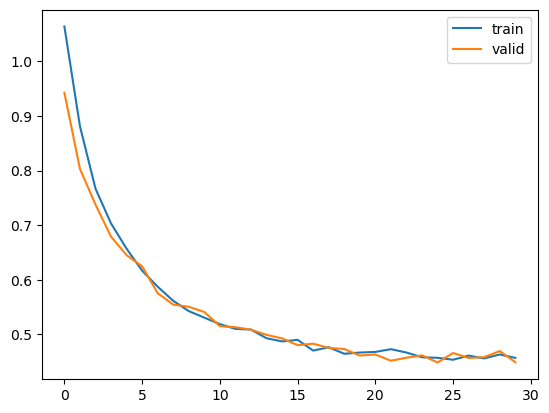

In [75]:
model.train()
losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

for epoch in range(NUM_EPOCHS):
    losses_epoch_train = []
    losses_epoch_test = []
    for x, cat_x, labels in train_data_loader:
        predictions = model(x, cat_x).squeeze(dim=1)
        loss = loss_fn(predictions, labels.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses_epoch_train.append(loss.item())
    losses_train.append(np.mean(losses_epoch_train))

    with torch.no_grad():
        for x, cat_x, labels in test_data_loader:
            predictions = model(x, cat_x).squeeze(dim=1)
            loss = loss_fn(predictions, labels.long())
            losses_epoch_test.append(loss.item())
        losses_test.append(np.mean(losses_epoch_test))
    
    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}, loss valid: {losses_epoch_test[-1]:.3}")


plt.figure()
plt.plot(losses_train)
plt.plot(losses_test)
plt.legend(["train", "valid"])

In [76]:
model.eval()

true_predictions, num_predictions = 0., 0.
true_predictions_cheap = 0.
true_predictions_expensive = 0.
true_predictions_average = 0.


with torch.no_grad():
        predictions = model(test_dataset[:][0], test_dataset[:][1])
        labels = test_dataset[:][2]
        prediction_labels = torch.max(predictions.data, 1).indices
        true_predictions += (prediction_labels == labels).sum()
        true_predictions_cheap += (torch.logical_and(prediction_labels == labels, prediction_labels == 0)).sum()
        true_predictions_average += (torch.logical_and(prediction_labels == labels, prediction_labels == 1)).sum()
        true_predictions_expensive += (torch.logical_and(prediction_labels == labels, prediction_labels == 2)).sum()
        num_predictions += labels.shape[0]
acc = true_predictions / num_predictions
acc_cheap = true_predictions_cheap / (labels == 0).sum()
acc_average = true_predictions_average / (labels == 1).sum()
acc_expensive = true_predictions_expensive / (labels == 2).sum()

print(f"Accuracy of the model: {100.0*acc:4.2f}%")
print(f"Cheap Accuracy of the model: {100.0*acc_cheap:4.2f}%")
print(f"Average Accuracy of the model: {100.0*acc_average:4.2f}%")
print(f"Expensive Accuracy of the model: {100.0*acc_expensive:4.2f}%")

print(f"Mean accuracy { (acc_expensive+acc_average+acc_cheap) / 3}")

Accuracy of the model: 84.03%
Cheap Accuracy of the model: 95.57%
Average Accuracy of the model: 81.64%
Expensive Accuracy of the model: 83.80%
Mean accuracy 0.8700261116027832
